author: leezeeyee   
date: 2021/4/16  
link: [github](https://github.com/easilylazy/pattern-recognition) 

In [1]:
import pandas as pd
import numpy as np

In [40]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

## load data

In [4]:
irisData=pd.read_csv('../multiClass/iris.csv')
irisData.head()

,Unnamed: 0,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,1,5.1,3.5,1.4,0.2,setosa
1,2,4.9,3.0,1.4,0.2,setosa
2,3,4.7,3.2,1.3,0.2,setosa
3,4,4.6,3.1,1.5,0.2,setosa
4,5,5.0,3.6,1.4,0.2,setosa


In [25]:
irisData.iloc[80]

Unnamed: 0              81
Sepal.Length           5.5
Sepal.Width            2.4
Petal.Length           3.8
Petal.Width            1.1
Species         versicolor
Name: 80, dtype: object

In [26]:
labelDict={}
labelDict['setosa']=0
labelDict['versicolor']=1
labelDict['virginica']=2

In [13]:
data=irisData[['Sepal.Length',	'Sepal.Width',	'Petal.Length',	'Petal.Width']]

In [20]:
data=np.asarray(data)

In [39]:
labels=np.zeros(len(data))

for key in labelDict:
    print(key)
    print(labelDict[key])
    # print( irisData[irisData['Species']==key].index.tolist())
    labels[irisData[irisData['Species']==key].index.tolist()]=labelDict[key]

setosa
0
versicolor
1
virginica
2


In [42]:
X=data
one_hot_Y=labels

In [46]:
trainX=[]
trainY=[]
testX=[]
testY=[]

for i in range(3):
    index=np.where(labels==i)[0]
    np.random.shuffle(index)
    
    trainX.append(X[index[:30]])
    trainY.append(labels[index[:30]])
    testX.append(X[index[30:]])
    testY.append(labels[index[30:]])
    print(index)
print(trainX[2][0])
print(X[index[0]])
trainX_all=np.r_[trainX[0],trainX[1],trainX[2]]
trainY_all=np.r_[trainY[0],trainY[1],trainY[2]]
indexTrain=np.arange(len(trainX_all))
np.random.shuffle(indexTrain)
trainX_sh=trainX_all[indexTrain]
trainY_sh=trainY_all[indexTrain]
testX_all=np.r_[testX[0],testX[1],testX[2]]
testY_all=np.r_[testY[0],testY[1],testY[2]]
indexTest=np.arange(len(testX_all))
np.random.shuffle(indexTest)
testX_sh=testX_all[indexTest]
testY_sh=testY_all[indexTest]

trainX_sh[:3]

[17 13 20 25  8 26 49  0 35 28  6 22 36 24 34 46  2 12 16  3 43  7  9 38
  5 41 11 47 15  4 44 40 29 23 31 37 33 21 30 14 39 48 18 10 42 45 27 32
  1 19]
[71 55 96 80 64 85 91 62 90 53 54 98 86 93 59 76 99 52 51 66 97 83 94 63
 81 58 82 68 61 65 73 78 50 69 77 57 92 95 56 89 74 87 67 84 70 79 60 72
 88 75]
[149 128 112 100 115 108 106 134 105 147 136 130 146 117 111 132 138 109
 143 124 121 120 113 145 116 141 119 135 133 148 118 107 131 114 137 122
 125 103 123 110 144 140 129 127 142 104 102 126 139 101]
[5.9 3.  5.1 1.8]
[5.9 3.  5.1 1.8]


array([[6.5, 3. , 5.2, 2. ],
       [7.4, 2.8, 6.1, 1.9],
       [5.5, 2.4, 3.7, 1. ]])

In [71]:
trainX_sh=trainX_sh.astype(np.float32)
testX_sh=testX_sh.astype(np.float32)

In [72]:
train_data=[]
test_data=[]
for i in range(len(trainX_sh)):
    train_data.append([trainX_sh[i],trainY_sh[i]])
for i in range(len(testX_sh)):
    train_data.append([testX_sh[i],testY_sh[i]])

In [73]:
batch_size = 3

# Create data loaders.
train_dataloader = DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X in train_dataloader:
    # print("Shape of X [N, C, H, W]: ", X.shape)
    print(X)
    # print("Shape of y: ", y.shape, y.dtype)
    break

[tensor([[7.2000, 3.6000, 6.1000, 2.5000],
        [5.4000, 3.7000, 1.5000, 0.2000],
        [6.3000, 3.3000, 6.0000, 2.5000]]), tensor([2., 0., 2.])]


In [74]:
print(next(iter(train_dataloader)))

[tensor([[4.8000, 3.0000, 1.4000, 0.1000],
        [7.7000, 3.0000, 6.1000, 2.3000],
        [4.8000, 3.0000, 1.4000, 0.3000]]), tensor([0., 2., 0.])]


In [75]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([3, 4])
Labels batch shape: torch.Size([3])


## model

In [76]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.ReLU(),
            nn.Linear(4, 8),
            nn.ReLU(),
            # nn.Linear(8, 3),
            nn.Linear(8, 5),
            nn.ReLU(),
            nn.Linear(5, 3),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Using cpu device


## train & test

In [120]:
def train(dataloader, model, loss_fn, optimizer, info=False):
    size = len(dataloader.dataset)

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction error
        pred = model(X)
        y=torch.tensor(y,dtype=torch.long)
        # print(pred,y)
        # print('sf')
        # print(pred[0][y[0]])
        loss = loss_fn(pred, y)
        # loss=(pred-y)**2
        # print(pred.argmax(1)==y)

        # print(loss)
        # print(loss.grad_fn)
        # Backpropagation
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        if info is True and batch % 50 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss

In [121]:
def test(dataloader, model, epoch, info=False):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            y=torch.tensor(y,dtype=torch.long)
            test_loss += loss_fn(pred, y).item()
            # print(pred)
            # print(pred.argmax(1))
            # print(y)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    if info is True and epoch%50==0:
        print(f"Epoch {t+1}\n-------------------------------")
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss,correct

In [122]:
model = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [140]:
epochs = 1
# fig=plt.figure()
maxCorrect=0
for t in range(epochs):
    
    train_loss=train(train_dataloader, model, loss_fn, optimizer,info=True)
    test_loss,test_correct=test(train_dataloader, model,t)
    if correct>maxCorrect:
        print(loss)
        print(correct)
        maxCorrect=correct
        if abs(maxCorrect-1)<1e-6:
            break
    # plt.plot(t,loss,'o')
print("Done!")

ipykernel_launcher:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
loss: 0.008246  [    0/  150]
ipykernel_launcher:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

0.09382967775066693
0.9733333333333334
Done!


In [114]:
## plot

ipykernel_launcher:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
ipykernel_launcher:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


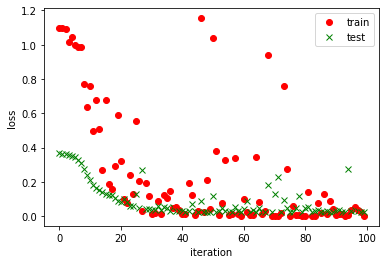

In [141]:
model = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
epochs = 100
fig=plt.figure()
maxCorrect=0
for t in range(epochs):
    
    train_loss=train(train_dataloader, model, loss_fn, optimizer)
    test_loss,test_correct=test(train_dataloader, model,t)
    if correct>maxCorrect:
        maxCorrect=correct
        if abs(maxCorrect-1)<1e-6:
            break
    plt.plot(t,train_loss.item(),'o',color='r')
    plt.plot(t,test_loss,'x',color='g')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend(['train','test'])